# **Art Classifier**

## **Non Structured Data**

This project has been done by:

|Name                    |Email                              |
|------------------------|-----------------------------------|
|Jorge Ayuso Martínez    |jorgeayusomartinez@alu.comillas.edu|
|Carlota Monedero Herranz|carlotamoh@alu.comillas.edu        |
|José Manuel Vega Gradit |josemanuel.vega@alu.comillas.edu   |

First of all, let's load the required libraries in order to run the code:

In [1]:
import os
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

2023-03-16 18:10:39.108012: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-16 18:10:39.108087: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-16 18:10:39.108094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
# If using Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Now let's see how our data is structured:

In [3]:
# Root folder
base_dir = "./data"

In [4]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [5]:
for path in os.walk(base_dir):
    for folder in path[1]:
        if ".ipynb_checkpoints" in folder:
            os.rmdir(os.path.join(path[0], folder))

Let's also see how many images there are for each class in the training, validation and test set.

In [6]:
# Number of classes
n_classes = len(os.listdir(train_dir))
print(f"Number of classes: {n_classes}")

# Get existing classes
classes = os.listdir(train_dir)
print("Existing classes:\n")
classes

Number of classes: 4
Existing classes:



['Renaissance', 'Realism', 'Baroque', 'Romanticism']

In [7]:
# Training
print("Number of images per class in Training set:")
print("="*50)
for cl in classes:
    n_images = len(os.listdir(os.path.join(train_dir, cl)))
    print(f"{cl}: {n_images}")

Number of images per class in Training set:
Renaissance: 4000
Realism: 4000
Baroque: 4000
Romanticism: 4000


In [8]:
# Validation
print("Number of images per class in Validation set:")
print("="*50)
for cl in classes:
    n_images = len(os.listdir(os.path.join(validation_dir, cl)))
    print(f"{cl}: {n_images}")

Number of images per class in Validation set:
Renaissance: 500
Realism: 500
Baroque: 500
Romanticism: 500


In [9]:
# Test
print("Number of images per class in Test set:")
print("="*50)
for cl in classes:
    n_images = len(os.listdir(os.path.join(test_dir, cl)))
    print(f"{cl}: {n_images}")

Number of images per class in Test set:
Renaissance: 500
Realism: 500
Baroque: 500
Romanticism: 500


## **1. Base model**

The first model we will create is a simple CNN. This will help us to have a general idea of how a very simple model would perform classifying art images, and try to improve this model by, for instance: 

* Upsampling the training dataset using Data Augmentation.
* Using regularization techniques such as $𝓛_1$, $𝓛_2$ or dropout.
* Incrementing the number of parameters of the CNN.
* Using pre-trained models (Transfer-Learning and Fine-Tuning).

### 1.1. Model structure

Let's first create the model structure:

In [10]:
model = models.Sequential()
# 1st Convolution Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)
                        )
)
# 1st Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 2nd Convolution Layer
model.add(layers.Conv2D(64
                        , (3, 3)
                        , activation='relu'
                        )
)
# 2nd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 3rd Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 3rd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 4th Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 4th Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

### 1.2. Data preprocessing

A critical step when creating these kind of models is how the input data is preprocessed. These involves:

* Normalize the input by dividing each pixel by its maximum value (i.e, 255).
* Define the input size, which affects to the final model.
* Batch size: this is the number of images in each batch.

In [13]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=100,
        # We use raw to get predicted probabilities
        class_mode='categorical'
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='categorical'
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


Now let's take a look at the output of one of these generators (for instance, the training one):

In [14]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 150, 150, 3)
labels batch shape: (100, 4)


*We can appreciate that...*

### 1.3. Training

Let's train the model:

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=10
      )

Epoch 1/100
 14/100 [===>..........................] - ETA: 2:05 - loss: 1.3836 - acc: 0.2764

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


100/100 [==============================] - 199s 2s/step - loss: 1.3047 - acc: 0.4000 - val_loss: 1.2326 - val_acc: 0.4580
Epoch 2/100
100/100 [==============================] - 193s 2s/step - loss: 1.1961 - acc: 0.4779 - val_loss: 1.2526 - val_acc: 0.4450
Epoch 3/100
100/100 [==============================] - 196s 2s/step - loss: 1.1435 - acc: 0.5124 - val_loss: 1.1034 - val_acc: 0.5200
Epoch 4/100
100/100 [==============================] - 191s 2s/step - loss: 1.1013 - acc: 0.5314 - val_loss: 1.1212 - val_acc: 0.5300
Epoch 5/100
100/100 [==============================] - 197s 2s/step - loss: 1.0786 - acc: 0.5415 - val_loss: 1.0550 - val_acc: 0.5520
Epoch 6/100
100/100 [==============================] - 189s 2s/step - loss: 1.0418 - acc: 0.5601 - val_loss: 1.0885 - val_acc: 0.5290
Epoch 7/100
100/100 [==============================] - 191s 2s/step - loss: 1.0258 - acc: 0.5676 - val_loss: 1.0780 - val_acc: 0.5500
Epoch 8/100
100/100 [==============================] - 195s 2s/step - loss

And once the model has been trained, we will save it:

In [16]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

# Directory where to save the model

# Save model
base_model_dir = os.path.join(models_dir, "model_v0.h5")
model.save(base_model_dir)

### 1.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

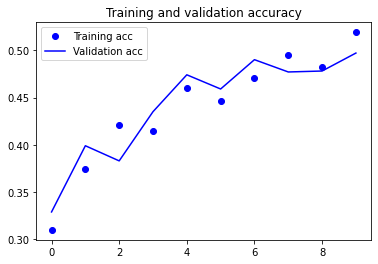

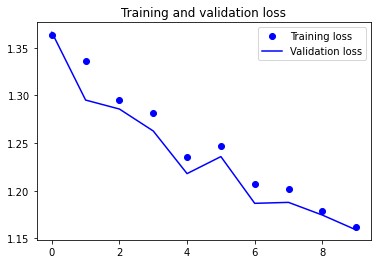

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*Comments about how those metrics have evolved...*

## **2. Including Dropout**

*Explain dropout, include reference to original paper*

### 2.1. Model structure

Let's first create the model structure:

In [18]:
model = models.Sequential()
# 1st Convolution Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)
                        )
)
# 1st Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 2nd Convolution Layer
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 2nd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 3rd Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 3rd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 4th Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 4th Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

We'll use Adam as our optimizer, as well as we have done previously due to the reasons already mentioned.

In [20]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

### 2.2. Data preprocessing

We'll apply the same preprocess steps we have performed for the base model.

In [21]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # We use raw to get predicted probabilities
        class_mode='categorical'
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical'
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


### 2.3. Training

Let's train the model:

In [22]:
history = model.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50
      )

/tmp/ipykernel_685/1048897212.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
50/50 [==============================] - 37s 713ms/step - loss: 1.3845 - acc: 0.2770 - val_loss: 1.3636 - val_acc: 0.3220
Epoch 2/10
50/50 [==============================] - 34s 681ms/step - loss: 1.3556 - acc: 0.3330 - val_loss: 1.3367 - val_acc: 0.3320
Epoch 3/10
50/50 [==============================] - 34s 691ms/step - loss: 1.3204 - acc: 0.3730 - val_loss: 1.3417 - val_acc: 0.3380
Epoch 4/10
50/50 [==============================] - 36s 736ms/step - loss: 1.3167 - acc: 0.4040 - val_loss: 1.3229 - val_acc: 0.3620
Epoch 5/10
50/50 [==============================] - 34s 678ms/step - loss: 1.2813 - acc: 0.4180 - val_loss: 1.2128 - val_acc: 0.4920
Epoch 6/10
50/50 [==============================] - 35s 704ms/step - loss: 1.2683 - acc: 0.4230 - val_loss: 1.2301 - val_acc: 0.4520
Epoch 7/10
50/50 [==============================] - 33s 672ms/step - loss: 1.2562 - acc: 0.4370 - val_loss: 1.2064 - val_acc: 0.4760
Epoch 8/10
50/50 [==============================] - 36s 713ms/step - 

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


50/50 [==============================] - 34s 687ms/step - loss: 1.1906 - acc: 0.4930 - val_loss: 1.1839 - val_acc: 0.4870
Epoch 10/10
50/50 [==============================] - 35s 701ms/step - loss: 1.1838 - acc: 0.4970 - val_loss: 1.1858 - val_acc: 0.4980


And once the model has been trained, we will save it:

In [23]:
# Save model
base_model_dir = os.path.join(models_dir, "model_v1.h5")
model.save(base_model_dir)

### 2.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

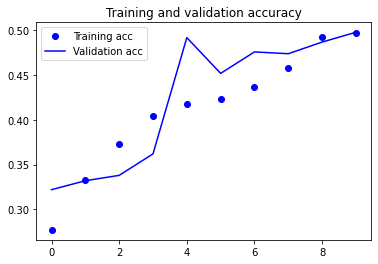

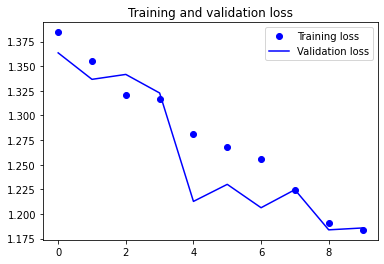

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*Comments about how those metrics have evolved... and compare them with prior results.*

## **3. Including Data Augmentation**

*Explain Data Augmentation, reference some website or paper which talks about this technique.*

### 3.1. Model structure

Let's first create the model structure:

In [25]:
model = models.Sequential()
# 1st Convolution Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)
                        )
)
# 1st Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 2nd Convolution Layer
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 2nd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 3rd Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 3rd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 4th Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 4th Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

We'll use Adam as our optimizer, as well as we have done previously due to the reasons already mentioned.

In [27]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

### 3.2. Data preprocessing

In this case, we will include the Data Augmentation step to the model preprocessing step...

In [28]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    )

# The data augmentation must not be used for the test set!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # We use raw to get predicted probabilities
        class_mode='categorical'
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical'
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


### 3.3. Training

Let's train the model:

In [29]:
history = model.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50
      )

Epoch 1/10
50/50 [==============================] - 41s 798ms/step - loss: 1.3919 - acc: 0.2610 - val_loss: 1.3713 - val_acc: 0.3250
Epoch 2/10
50/50 [==============================] - 41s 817ms/step - loss: 1.3708 - acc: 0.3140 - val_loss: 1.3410 - val_acc: 0.3750
Epoch 3/10
50/50 [==============================] - 36s 717ms/step - loss: 1.3512 - acc: 0.3670 - val_loss: 1.3311 - val_acc: 0.3910
Epoch 4/10
50/50 [==============================] - 38s 772ms/step - loss: 1.3566 - acc: 0.3160 - val_loss: 1.3239 - val_acc: 0.3810
Epoch 5/10
50/50 [==============================] - 41s 835ms/step - loss: 1.3136 - acc: 0.4080 - val_loss: 1.2777 - val_acc: 0.4250
Epoch 6/10
50/50 [==============================] - 41s 829ms/step - loss: 1.3182 - acc: 0.3830 - val_loss: 1.2789 - val_acc: 0.4060
Epoch 7/10
50/50 [==============================] - 40s 799ms/step - loss: 1.3123 - acc: 0.3800 - val_loss: 1.2755 - val_acc: 0.3980
Epoch 8/10
50/50 [==============================] - 39s 782ms/step - 

And once the model has been trained, we will save it:

In [30]:
# Save model
base_model_dir = os.path.join(models_dir, "model_v2.h5")
model.save(base_model_dir)

### 3.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

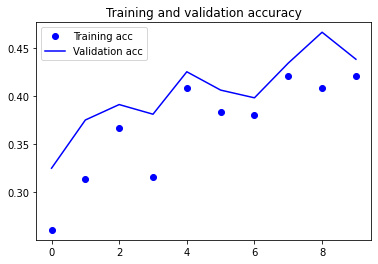

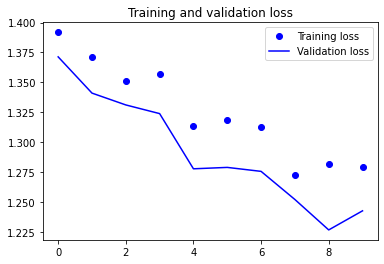

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*Comments about how those metrics have evolved... and compare those with prior results*

## **4. Model from scratch with best combination of hyperparameters found**

### 4.1. Model structure

Let's first create the model structure:

In [40]:
model = models.Sequential()
# 1st Convolution Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)
                        )
)
# 1st Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 2nd Convolution Layer
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 2nd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 3rd Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 3rd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 4th Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 4th Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 17, 17, 128)     

We'll use Adam as our optimizer, as well as we have done previouly due to the reasons already mentioned.

In [42]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

### 4.2. Data preprocessing

We'll apply the same preprocess steps we have performed for the base model.

In [43]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# The data augmentation must not be used for the test set!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # We use raw to get predicted probabilities
        class_mode='categorical'
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical'
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


### 4.3. Training

Let's train the model:

In [44]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=3,
      validation_data=validation_generator,
      validation_steps=50
      )

Epoch 1/3
100/100 [==============================] - 59s 572ms/step - loss: 0.5750 - acc: 0.2715 - val_loss: 0.5581 - val_acc: 0.3980
Epoch 2/3
100/100 [==============================] - 63s 629ms/step - loss: 0.5497 - acc: 0.3530 - val_loss: 0.5565 - val_acc: 0.3040
Epoch 3/3
100/100 [==============================] - 59s 595ms/step - loss: 0.5439 - acc: 0.3770 - val_loss: 0.5343 - val_acc: 0.3870


And once the model has been trained, we will save it:

In [46]:
# Save model
base_model_dir = os.path.join(models_dir, "model_v3.h5")
model.save(base_model_dir)

### 4.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

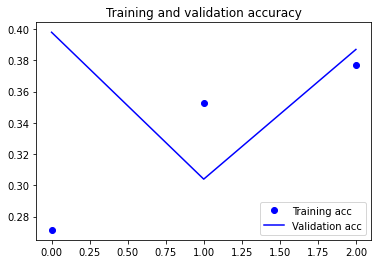

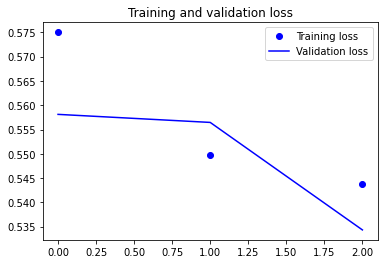

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*Comments about how those metrics have evolved...*

## **5. Fine-tuning**

We will use a pretrained model in order to compare its results with the results obtained with the models trained from scratch we already trained. Specifically, we will train a pretrained model found in Hugging Face which has 

First of all let's install the required libraries needed to run the pretrained model.

In [ ]:
!pip install ultralyticsplus==0.0.24 ultralytics==8.0.23

In [8]:
from ultralyticsplus import YOLO, postprocess_classify_output

# load model
model = YOLO('keremberke/yolov8m-painting-classification')

*Useful links for this model:*

[Hugging Face model link](https://huggingface.co/keremberke/yolov8m-painting-classification)

[Awesome Yolov8 models website](https://yolov8.xyz/#/?id=classification-models)

[Yolov8 GitHub page](https://github.com/ultralytics/ultralytics/blob/main/examples/tutorial.ipynb)

[Ultralytics website](https://docs.ultralytics.com/python/)